<a href="https://colab.research.google.com/github/dougmusser/Balthius_Optimizer/blob/main/Balthius_Backtest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Cindicator backtest using Balthius historical data</h1>

Credit to okadoke@ for making historical backtest data readily available.

<h2>Summary</h2>

<ul>
  <li>Buying calls when the average Cindicator indicator delta to the prior week is greater than zero providies a trading edge against always buying call options.
  <li>Optimizing indicator weights with the Skopt optimizer appears to improve performance, but backtesting the results by limiting the optimized window to Dec-2020 indicates the optimize parameters might not have an advantage.
  <li>Buying puts doesn't appear to help risk-adjusted returns. This is probaly due to the upwards bias of the underlying ETFs.
</ul>

<h2>What this CoLab Measures<h2>

<p>This CoLab starts with buying options on SPY and QQQ without any indicators and works thorugh to optimized weighted Cindicator indicator weights.

<p>Returns are measured using risk adjusted methos such as sharpe and calmar.

This CoLab compares the returns of:
<ol>
  <li>Always SPY and IWM calls each week. Do not use any Cindicator indicators. This provides a baseline without Cindicator data.
  <li>Baseline Inidcator Strategy. Buy calls on weeks when the average Cindicator indicator delta to the prior week is positive. This improves on always buying calls without Cindicator data.
  <li>Baseline Inidcator Strategy with Puts. Buy calls on weeks when the average Cindicator indicator delta to the prior week is positive and puts when the indicator delta to the prior week is negative. This doesn't improve returns.
  <li>Calls when indicator >0 strike 1% of underlying price. This mirrors the baseline indicator strategy but buys calls at strikes 1% above the underlying price. This doesn't improve returns.
  <li>Calls when indicator >0, ATM options, 2-week expiration. This mirrors the baseline indicator strategy but buys calls at expiration weeks two weeks from the current date. It sells after one week. This doesn't improve returns.
  <li>The above tests indicate using Cindicator indicator deltas ATM with a strike at the underlying price is the best approach. The next step is to optimize the indicator weights and the weight to apply to the prior week and measure the performance. This appears to improve returns, but it could be overfitting.
</ol>

<h2>Gotchas</h2>

This analysis doesn't include risk management. It assumes fixed trading sizes and returns are reported relative to the fixed trade size. The benefit of this approach is all periods of time have an equal weight. Sizing approaches
can skew the effect of some time periods on the final trading balance.

<h2>Next Steps</h2>

<ul>
  <li>Support selling portions of the trading position when the target is hit. This CoLab assumes a 100% sale when the target is reached.
  <li>Allow weighted indicator drift to re-optimize over time. This is diffcult due to the potential to overfit.
  <li>Run backtest on future returns over more time periods.
</ul>


In [ ]:
#@title Install External Packages

!pip install scikit-optimize

In [ ]:
#@title Imports and utility methods

import dataclasses
import gzip
import io
import itertools
import matplotlib.pyplot as plt
import matplotlib.ticker
import numpy as np
import os
import pandas as pd
import pickle
import re
import requests
import skopt
import skopt.space
import skopt.utils
import tqdm
import uuid
import typing
import zipfile
from IPython.display import display
from IPython.display import HTML
from IPython.display import Image

def get_sharpe(returns: pd.Series) -> np.float64:
  '''Returns the sharpe ratio for a series of returns.'''
  return np.sqrt(252) * returns.mean() / returns.std()

def get_calmar(returns: pd.Series) -> float:
  '''Returns Calmar ratio for a series of returns.

  I prefer Calmar since it maximizes the return on invested capital vs the
  downside risk. Shape tends to prefer strategies with low returns since they
  have less volatility.

  This implementation uses the cumulative sum of return instead of the
  geometric mean since this back-test enables the balance to go negative. Risk
  management and position sizing should be done outside of the optimizer.
  '''
  assert isinstance(returns.index.get_level_values(0)[0], pd.Timestamp)
  returns = returns.sort_index(level=0)
  sum_returns = returns.cumsum()
  rolling_max = sum_returns.expanding(min_periods=1).max()
  rolling_dd = rolling_max - sum_returns
  max_rolling_dd = rolling_dd.max()
  if max_rolling_dd <= 0:
    # Reject strategies that don't have draw downs. They're not realistic.
    return 0
  return sum_returns.iloc[-1] / max_rolling_dd


def get_truncated_calmar(returns: pd.Series,
                         threshold: float=0.6) -> np.float64:
  '''Returns a Calmar ratio with the positive returns truncated.

  This reduces the effect of outliers when optimizing a strategy.
  '''
  positive_returns = returns.loc[returns > 0]
  if positive_returns.empty:
    # No positive returns
    return get_calmar(returns)
  returns = returns.copy()
  # Truncate the largest returns.
  returns.loc[returns > positive_returns.quantile(threshold)] = (
      positive_returns.quantile(threshold))
  return get_calmar(returns)

def get_annualized_mean(returns: pd.Series) -> np.float64:
  '''Get the annualized mean returns.'''
  assert isinstance(returns.index.get_level_values(0)[0], pd.Timestamp)
  start_date = returns.index.get_level_values(0).min()
  end_date = returns.index.get_level_values(0).max()
  num_years = ((end_date - start_date).days / 365)
  # Annualized mean returns is the sum returns divided by the number
  # of years.
  return returns.sum() / num_years

def skopt_gp_minimize(
    space: typing.List[skopt.Space],
    score_returns_fn,
    n_calls=100,
    **get_returns_kwargs):
  '''Run skopt.gp_minimize for a given return scoring function.

  This is a convenience wrapper for the conventions setup in this CoLab.
  '''
  
  with tqdm.trange(n_calls, desc='running gp_minimize') as t:
    @skopt.utils.use_named_args(space)
    def wrapped_objective(**kwargs):
      get_return_args = {}
      get_return_args.update(get_returns_kwargs)
      get_return_args.update(kwargs)
      returns = get_returns(**get_return_args)
      try:
        if returns.empty:
          return 0
        return -score_returns_fn(returns)
      finally:
        t.update()

    return skopt.gp_minimize(
        wrapped_objective, space, n_calls=n_calls, random_state=0, n_jobs=-1)

/home/dougmusser/py38/lib/python3.8/site-packages/pandas/compat/__init__.py:97: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [ ]:
#@title Download & Parse Cindicator data. Create a method to get the returns given parameters.

# Download Cindicator data
# Insert the URL for Balthius_Weekly_Cindicator_Exports_20210307.zip here.
weekly_cindicator_export_url = 'INSERT URL FOR Balthius_Weekly_Cindicator_Exports_20210307.zip' #@param
if weekly_cindicator_export_url.startswith('INSERT'):
  weekly_cindicator_export_url = (
      input(
          'Input Balthius_Weekly_Cindicator_Exports_20210307.zip URL. '
          'E.g.: https://cdn.discordapp.com/attachments/...'))
response = requests.get(weekly_cindicator_export_url, stream=True)
assert response.status_code == 200
zip_bytes = response.raw.read()

# Parse Cindicator data
option_data = []
with zipfile.ZipFile(io.BytesIO(zip_bytes)) as zf:
  for idx, f in enumerate(zf.filelist):
    match = re.match(
        r'Balthius ([A-Z][A-Z][A-Z]+) (\dpct OTM|ATM) (\d) Week Exp '
        r'(\d{4}-\d{2}-\d{2})\.csv', f.filename)
    if not match:
      raise Exception(f'Unexpected filename: {f.filename}')
    underlying_symbol, trade_target, week_exp, data_date = match.groups()

    # Process trade_target
    trade_target_pct_match = re.match(r'(\d)pct OTM', trade_target)
    if trade_target == 'ATM':
      strike_pct = 0
    elif trade_target_pct_match:
      strike_pct = int(trade_target_pct_match.groups()[0])
    else:
      raise Exception(f'Unexpected trade_target={trade_target}')
    # Process week_exp
    week_exp = int(week_exp)
    # Process data_date
    data_date = pd.Timestamp(data_date).normalize()

    with zf.open(f) as option_csv_content:
      option_data_part = pd.read_csv(
          option_csv_content, parse_dates=['Week Starting'],
          index_col=['Week Starting'])
      # print(option_data_part.columns)
    # Reduce option_data_part to the columns of interest - also ensures the
    # columns of interest are present in the DataFrame.
    # Rename the columns to improve readability.
    # Assign the filename identifiers to the DataFrame.
    option_data.append(
      option_data_part[[
        'Open', 'Gap', 'ESC', 'ESF', 'ECC', 'BEF', 'PSC', 'PEF',
        'CStrike', 'COC1', 'COH1',
        'PStrike', 'POC1', 'POH1',
      ]].rename(columns=dict(
          Open='underlying_open', Gap='underlying_gap',
          CStrike='c_strike', PStrike='put_strike')
      ).assign(
        underlying_symbol=underlying_symbol
      ).assign(
        strike_pct=strike_pct
      ).assign(
        week_exp=week_exp
      ).assign(
        data_date=data_date
      ).set_index(
          ['underlying_symbol', 'strike_pct', 'week_exp'], append=True
      ))
option_data = pd.concat(option_data).sort_index()
# Ensure there are no duplicates
assert not option_data.index.duplicated().any()
display(option_data.head(2))
display(f'option_data length: {len(option_data)}')

#@title Extract Cindicator indicators from a random slice since the indicators are duplicated within the spreadsheet
indicators = option_data.loc[
  pd.IndexSlice[:, 'SPY', 0, 1],
  ['ESC', 'ESF', 'ECC', 'BEF', 'PSC', 'PEF']
].copy()
indicators = indicators.set_index(
    indicators.index.get_level_values('Week Starting')).sort_index()
assert not indicators.index.duplicated().any()
# Calculate indicator changes. Use changes of the log of the indicators instead
# of percentage changes to minimize outliers. Expect all indicators to be > 1,
# otherwise log will have issues. If this ever happens this code will need to
# special-case handle zero values.
assert (indicators > 0).all().all()
indicator_changes = np.log(indicators).sub(np.log(indicators).shift(1)).dropna()
indicator_changes.head(2)

def get_returns(
    symbol, esc_weight, esf_weight, ecc_weight, bef_weight, psc_weight,
    pef_weight, strike_pct, week_exp,
    # ratio_of_balance_to_trade,
    last_week_weight, buy_puts_when_indicator_is_negative,
    call_sell_trigger_pct, put_sell_trigger_pct,
    backtest_date_cuttoff: typing.Optional[pd.Timestamp] = None):
  '''Compute the option returns for a given set of parameters.

  This uses the indicator_changes values above.
  '''

  # Computed the weighted indicator.
  permutation_indicator = (
    (indicator_changes['ESC'] * esc_weight)
    + (indicator_changes['ESF'] * esf_weight)
    + (indicator_changes['ECC'] * ecc_weight)
    + (indicator_changes['BEF'] * bef_weight)
    + (indicator_changes['PSC'] * psc_weight)
    + (indicator_changes['PEF'] * pef_weight))
  permutation_indicator = (
      permutation_indicator +
      permutation_indicator.shift(1).mul(last_week_weight)).dropna()
  # Join the weighted indicators with the historical option data to enable
  # applying the indicator results below. We can't use the indicator values
  # in the option_data data frame since it's difficult to apply the
  # last_week_weight parameter in that fashion.
  option_data_with_indicators = option_data.loc[
    pd.IndexSlice[
      option_data.index.get_level_values('Week Starting').isin(
          permutation_indicator.index),
      symbol, strike_pct:strike_pct, week_exp:week_exp]]
  option_data_with_indicators = (
      option_data_with_indicators.assign(
          indicator=permutation_indicator.loc[
            option_data_with_indicators.index.get_level_values('Week Starting')
          ].values))
  if backtest_date_cuttoff is not None:
    option_data_with_indicators = option_data_with_indicators.loc[
      pd.IndexSlice[:backtest_date_cuttoff, :, :, :], :]

  # Start off with assuming zero returns (no trading) for each week.
  returns = pd.Series(0, option_data_with_indicators.index)

  # Apply the call on close returns where the indicator is positive.
  returns.loc[option_data_with_indicators['indicator'] > 0] = (
      option_data_with_indicators['COC1'])
  # Apply the call sell trigger where the indicator is positive when the option
  # high return was at least as high as call_sell_trigger_pct. If the option
  # high didn't meet call_sell_trigger_pct then the COC1 value above is used
  # for the return.
  if call_sell_trigger_pct:
    returns.loc[
        (option_data_with_indicators['indicator'] > 0)
        & (option_data_with_indicators['COH1'] >= call_sell_trigger_pct)
    ] = call_sell_trigger_pct
  # This back-tests puts depending on buy_puts_when_indicator_is_negative.
  if buy_puts_when_indicator_is_negative:
    # Apply the put on close returns where the indicator is negative.
    returns.loc[option_data_with_indicators['indicator'] < 0] = (
        option_data_with_indicators['POC1'])
    # Apply the put sell trigger where the indicator is negative when the option
    # high return was at least as high as put_sell_trigger_pct. If the option
    # high didn't meet put_sell_trigger_pct then POC1 value above is used for
    # the return.
    if put_sell_trigger_pct:
      returns.loc[
        (option_data_with_indicators['indicator'] < 0)
        & (option_data_with_indicators['POH1'] >= put_sell_trigger_pct)
      ] = put_sell_trigger_pct
  # Remove strange values.
  returns.loc[np.isinf(returns)] = None
  return returns

Input Balthius_Weekly_Cindicator_Exports_20210307.zip URL. E.g.: https://cdn.discordapp.com/attachments/...https://cdn.discordapp.com/attachments/786492289236205618/818166051966550046/Balthius_Weekly_Cindicator_Exports_20210307.zip


underlying_open  \
Week Starting underlying_symbol strike_pct week_exp                    
2019-12-09    IWM               0          1                  162.75   
                                           2                  162.75   

                                                     underlying_gap  ESC  ESF  \
Week Starting underlying_symbol strike_pct week_exp                             
2019-12-09    IWM               0          1                  -0.07   44   47   
                                           2                  -0.07   44   47   

                                                     ECC  BEF  PSC  PEF  \
Week Starting underlying_symbol strike_pct week_exp                       
2019-12-09    IWM               0          1          59   47   48   44   
                                           2          59   47   48   44   

                                                     c_strike  COC1  COH1  \
Week Starting underlying_symbol strike_pct week_exp                         
2019-12-09    IWM               0          1              163 -0.70  1.16   
                                           2              163 -0.37  0.74   

                                                     put_strike  POC1  POH1  \
Week Starting underlying_symbol strike_pct week_exp                           
2019-12-09    IWM               0          1                163 -0.98  0.37   
                                           2                163 -0.38  0.26   

                                                     data_date  
Week Starting underlying_symbol strike_pct week_exp             
2019-12-09    IWM               0          1        2021-03-07  
                                           2        2021-03-07

'option_data length: 1040'

,annualized_mean,calmar,sharpe
underlying_symbol,,,
IWM,-24%,-5%,-0.1
QQQ,948%,226%,2.2
SPY,331%,74%,0.8


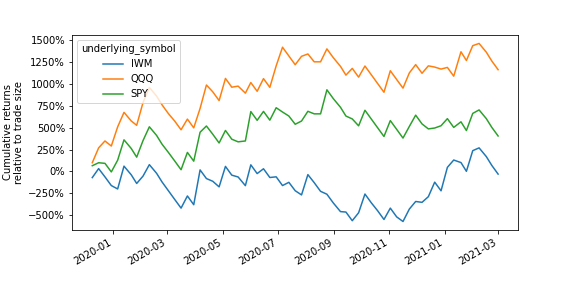

,annualized_mean,calmar,sharpe,annualized_mean_vs_no_indicator,calmar_vs_no_indicator,sharpe_vs_no_indicator
underlying_symbol,,,,,,
IWM,"1,079%",553%,3.2,"1,103%",558%,3.2
QQQ,"1,309%",778%,4.0,360%,552%,1.8
SPY,"1,431%","1,070%",4.3,"1,100%",996%,3.5


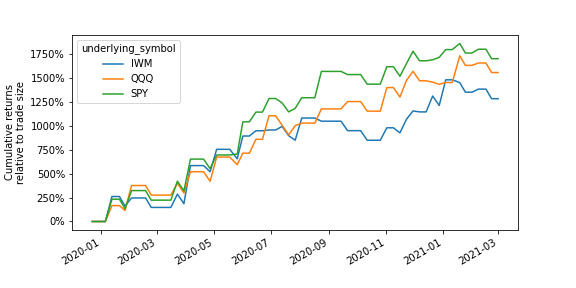

,annualized_mean,calmar,sharpe,annualized_mean_vs_call_only,calmar_vs_call_only,sharpe_vs_call_only
underlying_symbol,,,,,,
IWM,"1,423%",272%,3.0,344%,-281%,-0.2
QQQ,686%,202%,1.7,-622%,-576%,-2.3
SPY,"1,267%",455%,2.9,-164%,-615%,-1.4


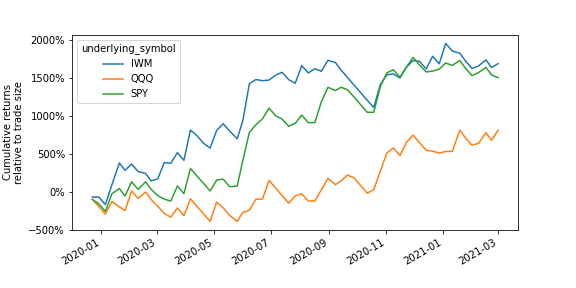

,annualized_mean,calmar,sharpe,annualized_mean_vs_call_only,calmar_vs_call_only,sharpe_vs_call_only
underlying_symbol,,,,,,
IWM,"1,447%",550%,3.0,368%,-3%,-0.2
QQQ,"1,439%",512%,3.5,130%,-266%,-0.5
SPY,"1,844%",419%,3.5,414%,-651%,-0.8


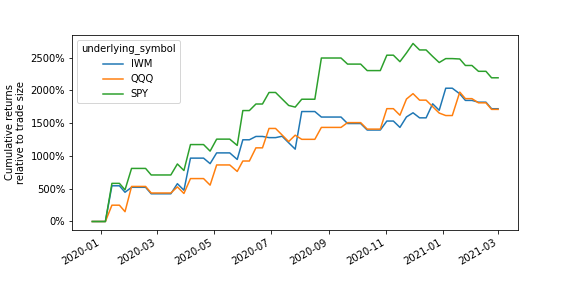

,annualized_mean,calmar,sharpe,annualized_mean_vs_call_only,calmar_vs_call_only,sharpe_vs_call_only
underlying_symbol,,,,,,
IWM,874%,866%,3.9,-205%,313%,0.8
QQQ,821%,606%,4.0,-488%,-172%,0.0
SPY,873%,805%,4.3,-558%,-265%,0.0


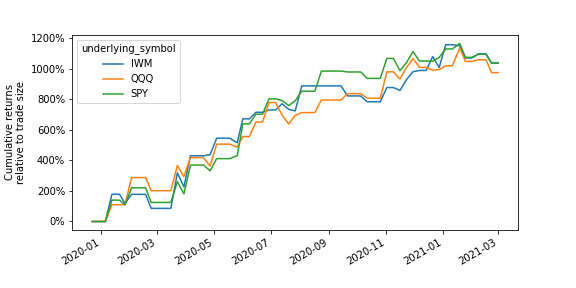

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [ ]:
#@title Compare the results of various strategies to explore how different configurations affect returns. This is a prelude into using a risk-adjusted optimizer to find an ideal trading parameter setting.


def get_returns_with_defaults_params(
    symbol, esc_weight=1, esf_weight=1, ecc_weight=1, bef_weight=1,
    psc_weight=1, pef_weight=1, strike_pct=0, week_exp=1, last_week_weight=0,
    buy_puts_when_indicator_is_negative=False, call_sell_trigger_pct=0,
    put_sell_trigger_pct=0) -> pd.Series:
  return get_returns(
      symbol=symbol, esc_weight=esc_weight, esf_weight=esf_weight,
      ecc_weight=ecc_weight, bef_weight=bef_weight, psc_weight=psc_weight,
      pef_weight=pef_weight, strike_pct=strike_pct, week_exp=week_exp,
      last_week_weight=last_week_weight,
      buy_puts_when_indicator_is_negative=buy_puts_when_indicator_is_negative,
      call_sell_trigger_pct=call_sell_trigger_pct,
      put_sell_trigger_pct=put_sell_trigger_pct)


def get_benchmarks(returns: pd.Series) -> pd.DataFrame:
  return (
      returns.groupby(level='underlying_symbol')
      .agg(annualized_mean=get_annualized_mean, calmar=get_calmar,
           sharpe=get_sharpe))


def format_benchmarks(benchmarks: pd.DataFrame) -> pd.DataFrame:
  ret = benchmarks.copy()
  for col, format in {
      'annualized_mean': '{:,.0%}',
      'calmar': '{:,.0%}',
      'sharpe': '{:,.1f}'}.items():
    ret[col] = ret[col].map(format.format)
  return ret


def disply_trading_results(
    title: str, desc: str, symbols=('SPY', 'IWM', 'QQQ'),
    returns: pd.Series=None, comp_benchmarks: pd.DataFrame=None,
    comp_benchmarks_name: str='', end_with_hr: bool=True,
    **kwargs):

  if returns is None:
    # Compute returns if not provided
    returns = pd.concat(
      get_returns_with_defaults_params(symbol=symbol, **kwargs)
      for symbol in symbols)
  plt.figure()
  ax = (
      returns.droplevel(['strike_pct', 'week_exp']).unstack('underlying_symbol')
      .cumsum()
  ).plot(figsize=(8, 4))
  ax.xaxis.set_label_text('')
  ax.yaxis.set_label_text('Cumulative returns\nrelative to trade size')
  ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(1))
  imgbuf = io.BytesIO()
  plt.savefig(imgbuf)
  imgbuf.flush()
  plt.close()
  benchmarks = get_benchmarks(returns)
  benchmarks_for_display = format_benchmarks(benchmarks)
  if comp_benchmarks is not None:
    comp_benchmarks = benchmarks.sub(comp_benchmarks)
    comp_benchmarks_for_display = format_benchmarks(comp_benchmarks)
    assert comp_benchmarks_name
    benchmarks_for_display = benchmarks_for_display.join(
        comp_benchmarks_for_display, rsuffix=f'_vs_{comp_benchmarks_name}')
  display(
      HTML(f'<h2>{title}</h2>{desc}'),
      benchmarks_for_display,
      Image(imgbuf.getvalue()))
  if end_with_hr:
    display(HTML('<hr>'))
  return benchmarks

no_indicator_benchmarks = disply_trading_results(
    title='No indicators, Always buy calls',
    desc=('The results of not using any indicators.\n'
          'Cindicator results are compared to these results'),
    returns=option_data.loc[pd.IndexSlice[:, :, 0, 1], 'COC1'])
call_only_benchmarks = disply_trading_results(
    title='Baseline Indicator Strategy',
    desc=(
        'Buy 1 Week ATM calls when indicator mean is postitive<p>'
        'The indicators demonstrate significant improvements to returns.<p>'
        'The returns are higher as measured in mean returns and risk '
        'adjusted Calmar and shapre returns.'
        '<h3>Analysis</h3>'
        'Use the indicators as a signal for trading vs always buying calls.'),
    comp_benchmarks=no_indicator_benchmarks,
    comp_benchmarks_name='no_indicator')
disply_trading_results(
    title='Baseline Indicator Strategy with Puts',
    desc=(
        'Buy 1 Week ATM calls when indicator mean is postitive<br>'
        'and 1 week ATM puts when indicator mean is negative<p/>'
        'Adding puts improves IWM reutrns but reduces SPY returns.<br>'
        'This comes at the cost of <b>increased risk</b> as measured by Calmar '
        'sharpe ratios.<br>'
        'Traing puts means reducing position sizes to account for risk '
        'increase'
        '<h3>Analysis</h3>'
        '<b>Do not trade puts</b>, they always increase risk and sometimes '
        'increase returns'),
    buy_puts_when_indicator_is_negative=True,
    comp_benchmarks=call_only_benchmarks,
    comp_benchmarks_name='call_only')
disply_trading_results(
    title='Calls when indicator >0 strike 1% of underlying price',
    desc=(
        'This approach increases overall all returns but '
        '<b>decreases</b> returns when accounting for risk as measured<br>'
        'by Calmar and sharpe. It would require reduced position sizes to '
        'trade.'
        '<h3>Analysis</h3>'
        'Do not use due to increased risk.'),
    strike_pct=1,
    comp_benchmarks=call_only_benchmarks,
    comp_benchmarks_name='call_only')
disply_trading_results(
    title='Calls when indicator >0, ATM options, 2-week expiration',
    desc=(
        'This approach decreaes returns and varies based on risk adjusted '
        'Calmar and sharpe returns.<br>'
        '<h3>Analysis</h3>'
        'Do not use. This does not improve on the baseline indicator strategy.'),
    week_exp=2,
    comp_benchmarks=call_only_benchmarks,
    comp_benchmarks_name='call_only')
None # Don't display the return value of the last line in the cell

In [ ]:
#@title Optimize weights over all historical data
# Configuration of indicator weights to optimize.
indicator_weight_optimize_space = [
  skopt.space.Real(-1, 1, name='esc_weight'),
  skopt.space.Real(-1, 1, name='esf_weight'),
  skopt.space.Real(-1, 1, name='ecc_weight'),
  skopt.space.Real(-1, 1, name='bef_weight'),
  skopt.space.Real(-1, 1, name='psc_weight'),
  skopt.space.Real(-1, 1, name='pef_weight'),
  skopt.space.Real(0, 1, name='last_week_weight')]

call_sell_trigger_pct_space = skopt.space.Real(0, 8,
                                               name='call_sell_trigger_pct')

# Hard coded parameters for one-week ATM optimiztion.
one_week_atm_hard_coded_space = dict(
    strike_pct=0,
    week_exp=1,
    buy_puts_when_indicator_is_negative=False,
    put_sell_trigger_pct=0)

@dataclasses.dataclass
class OptimizedParameters(object):
  # Symbol to optimize
  symbol: str
  # Params to optimize
  optimize_space: typing.List[skopt.space.Space]
  # Hard-coded parameters. Fixed parameters that aren't optimized.
  hard_coded_space: typing.Dict[str, typing.Any]
  # Number of calls to optimize over. 800 takes ~4-hours
  n_optimize_calls: int = 100
  # Function that scores returns. E.g. mean of returns, Calmar of returns,
  # sharpe of returns, etc
  score_returns_fn: typing.Callable[[pd.Series], float] = get_truncated_calmar

  results = None

  def optimize(self):
    with tqdm.trange(self.n_optimize_calls,
                     desc=f'gp_minimize for {self.symbol}') as t:
      optimize_space = self.optimize_space
      num_objective_calls = [0]
      @skopt.utils.use_named_args(optimize_space)
      def objective(**kwargs):
        t.update()
        num_objective_calls[0] += 1
        with open('/tmp/num_objective.txt', 'w') as fout:
          fout.write(
              f'{self.symbol}: num_objective_calls={num_objective_calls[0]}\n')
        duplicated_keys = set(self.hard_coded_space.keys()).intersection(kwargs.keys())
        assert not duplicated_keys, duplicated_keys
        get_return_args = dict(symbol=self.symbol)
        get_return_args.update(self.hard_coded_space)
        get_return_args.update(kwargs)
        returns = get_returns(**get_return_args)
        if returns.empty:
          return 0
        # Negative since gp_minimize minimizes results, but we want to maximize.
        return -self.score_returns_fn(returns)

      self.results = skopt.gp_minimize(
          objective, optimize_space, n_calls=self.n_optimize_calls,
          random_state=0, n_jobs=-1)
      # Persist the results.
      del objective
      out_path = os.path.join(
          '/tmp/',
          f'results.{self.symbol}.{self.n_optimize_calls}.{uuid.uuid1()}.pickle.gz')
      print(f'\nwriting optimize results to {out_path}')
      with gzip.GzipFile(out_path, mode='wb') as gout:
        pickle.dump(self.results.x_iters, gout)
    return self

  @property
  def optimize_calls(self) -> pd.DataFrame:
    assert self.results is not None, 'optimize() has not been run yet'
    results_list = [
      dict(zip((s.name for s in self.optimize_space), i))
      for i in self.results.x_iters]
    for res in results_list:
      get_returns_args = dict(symbol=self.symbol)
      get_returns_args.update(self.hard_coded_space)
      get_returns_args.update(res)
      returns = get_returns(**get_returns_args)
      res['mean_returns'] = returns.mean()
      res['calmar'] = get_calmar(returns)
      res['truncated_calmar'] = get_truncated_calmar(returns)
      res['sharpe'] = get_sharpe(returns)
      res['returns'] = returns
      res['get_returns_args'] = get_returns_args
    return pd.DataFrame.from_records(results_list).sort_values(
        'truncated_calmar', ascending=False)

  def display_results(self, title: str):
    optimize_calls = self.optimize_calls
    # Render the plot
    plt.figure()
    optimize_calls.sort_index()[[
      'truncated_calmar', 'mean_returns', 'get_returns_args']].plot(
        title=(
            'Truncated Calmar & Mean Returns vs. gp_minimize iteration\n'
            'These values should rise as the iterations improve'),
        secondary_y='mean_returns',
        linewidth=1,
        figsize=(20, 4))
    imgbuf = io.BytesIO()
    plt.savefig(imgbuf)
    imgbuf.flush
    plt.close()


    display(
        HTML(f'<h1>{title}</h1>'),
        HTML('<h2>Best scoring optimized parameters</h2>'),
        optimize_calls.drop('returns', axis=1).head(5))
    display(Image(imgbuf.getvalue()))

n_optimize_calls = 600
spy_1_week_atm_optimization = OptimizedParameters(
    symbol='SPY',
    n_optimize_calls=n_optimize_calls,
    optimize_space=(indicator_weight_optimize_space
                    + [call_sell_trigger_pct_space]),
    hard_coded_space=one_week_atm_hard_coded_space
).optimize()
iwm_1_week_atm_optimization = OptimizedParameters(
    symbol='IWM',
    n_optimize_calls=n_optimize_calls,
    optimize_space=(indicator_weight_optimize_space
                    + [call_sell_trigger_pct_space]),
    hard_coded_space=one_week_atm_hard_coded_space
).optimize()
qqq_1_week_atm_optimization = OptimizedParameters(
    symbol='QQQ',
    n_optimize_calls=n_optimize_calls,
    optimize_space=(indicator_weight_optimize_space
                    + [call_sell_trigger_pct_space]),
    hard_coded_space=one_week_atm_hard_coded_space
).optimize()

,esc_weight,esf_weight,ecc_weight,bef_weight,psc_weight,pef_weight,last_week_weight,call_sell_trigger_pct,mean_returns,calmar,truncated_calmar,sharpe,get_returns_args
548,0.719887,-0.812372,0.584958,0.572236,-0.695431,0.995379,0.110528,0.689390,0.226415,14.264128,14.264128,7.612264,"{'symbol': 'SPY', 'strike_pct': 0, 'week_exp':..."
554,0.702383,-0.791591,0.583638,0.537683,-0.688450,1.000000,0.111598,0.687657,0.225700,14.219087,14.219087,7.599688,"{'symbol': 'SPY', 'strike_pct': 0, 'week_exp':..."
474,1.000000,-0.850715,0.681958,0.755788,-0.715817,0.986285,0.091030,0.684799,0.224520,14.144778,14.144778,7.578840,"{'symbol': 'SPY', 'strike_pct': 0, 'week_exp':..."
489,1.000000,-0.841598,0.664906,0.794584,-0.717980,0.993594,0.086884,0.683255,0.223883,14.104642,14.104642,7.567528,"{'symbol': 'SPY', 'strike_pct': 0, 'week_exp':..."
556,0.667168,-0.850552,0.480237,0.590184,-0.677895,1.000000,0.109429,0.678071,0.221743,13.969838,13.969838,7.529261,"{'symbol': 'SPY', 'strike_pct': 0, 'week_exp':..."


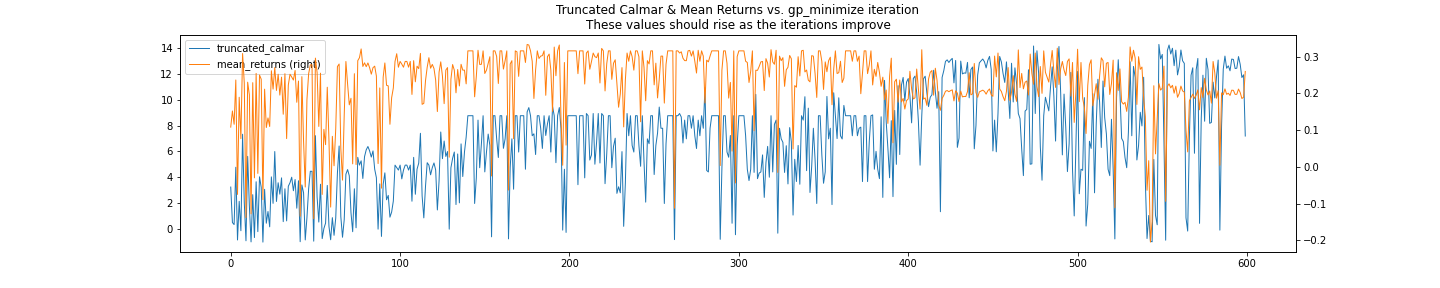

,esc_weight,esf_weight,ecc_weight,bef_weight,psc_weight,pef_weight,last_week_weight,call_sell_trigger_pct,mean_returns,calmar,truncated_calmar,sharpe,get_returns_args
550,0.947948,-0.183280,0.288319,1.0,-1.0,-1.0,0.034189,2.787925,0.376343,15.496487,13.946405,5.645150,"{'symbol': 'IWM', 'strike_pct': 0, 'week_exp':..."
574,0.829584,-0.236665,0.340614,1.0,-1.0,-1.0,0.144302,3.018469,0.368792,15.185539,13.299346,5.357965,"{'symbol': 'IWM', 'strike_pct': 0, 'week_exp':..."
568,0.829980,-0.247839,0.357156,1.0,-1.0,-1.0,0.155801,2.925853,0.371576,15.300172,13.299346,5.377954,"{'symbol': 'IWM', 'strike_pct': 0, 'week_exp':..."
579,0.828552,-0.242779,0.368342,1.0,-1.0,-1.0,0.146847,2.978686,0.375769,15.472829,13.299346,5.389643,"{'symbol': 'IWM', 'strike_pct': 0, 'week_exp':..."
578,0.828911,-0.241482,0.362094,1.0,-1.0,-1.0,0.146179,2.987070,0.376434,15.500228,13.299346,5.391434,"{'symbol': 'IWM', 'strike_pct': 0, 'week_exp':..."


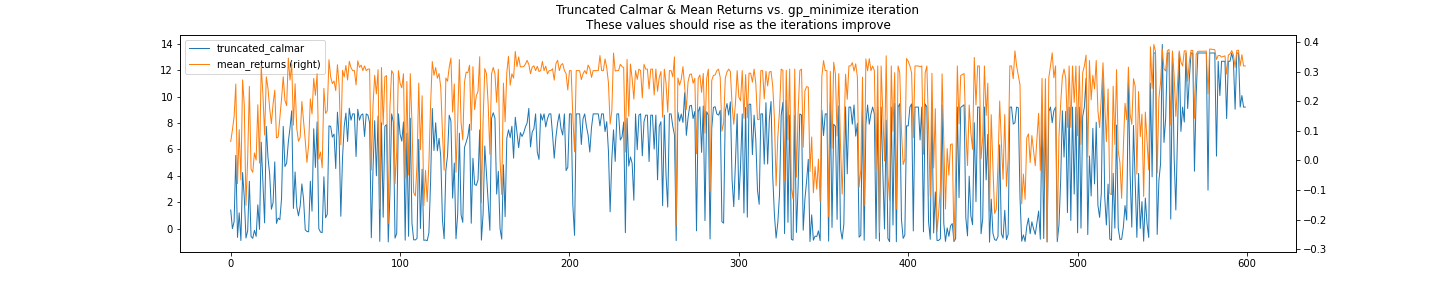

,esc_weight,esf_weight,ecc_weight,bef_weight,psc_weight,pef_weight,last_week_weight,call_sell_trigger_pct,mean_returns,calmar,truncated_calmar,sharpe,get_returns_args
460,0.295140,-0.448264,-1.0,1.0,-0.347524,0.257589,1.0,1.783834,0.362818,22.857515,22.857515,6.329039,"{'symbol': 'QQQ', 'strike_pct': 0, 'week_exp':..."
453,0.282776,-0.443693,-1.0,1.0,-0.335279,0.243068,1.0,1.774382,0.360567,22.715727,22.715727,6.314544,"{'symbol': 'QQQ', 'strike_pct': 0, 'week_exp':..."
465,0.314785,-0.453382,-1.0,1.0,-0.370133,0.237564,1.0,1.767886,0.359020,22.618287,22.618287,6.304500,"{'symbol': 'QQQ', 'strike_pct': 0, 'week_exp':..."
450,0.287011,-0.445397,-1.0,1.0,-0.345505,0.230208,1.0,1.762907,0.357835,22.543599,22.543599,6.296755,"{'symbol': 'QQQ', 'strike_pct': 0, 'week_exp':..."
457,0.284996,-0.437372,-1.0,1.0,-0.324192,0.252869,1.0,1.805646,0.352138,22.184689,22.184689,5.989802,"{'symbol': 'QQQ', 'strike_pct': 0, 'week_exp':..."


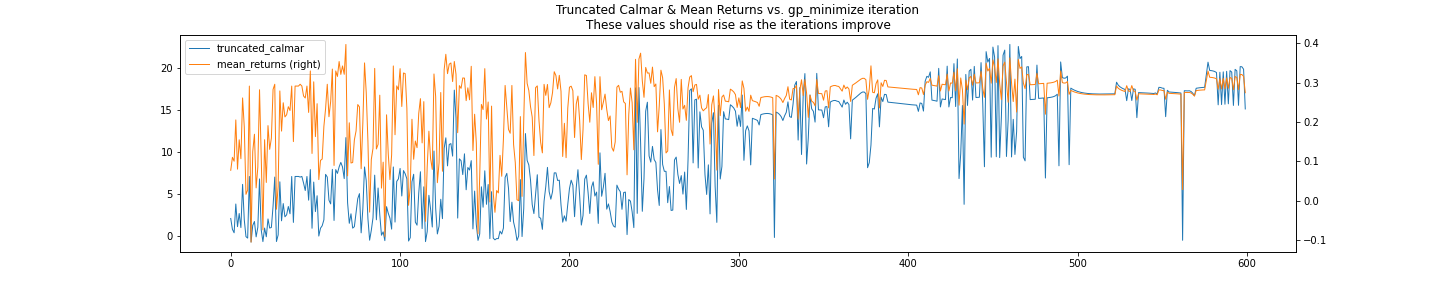

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [23]:
#@title Display Optimized Parameters
spy_1_week_atm_optimization.display_results('SPY Optimized Results')
iwm_1_week_atm_optimization.display_results('IWM Optimized Results')
qqq_1_week_atm_optimization.display_results('QQQ Optimized Results')

,annualized_mean,calmar,sharpe
underlying_symbol,,,
IWM_indicator_mean,10.790207,5.530172,3.155059
IWM_optimized,19.940123,15.496487,5.645150
QQQ_indicator_mean,13.086175,7.780000,3.963385
QQQ_optimized,19.223486,22.857515,6.329039
SPY_indicator_mean,14.305645,10.698113,4.257692
SPY_optimized,11.996329,14.264128,7.612264


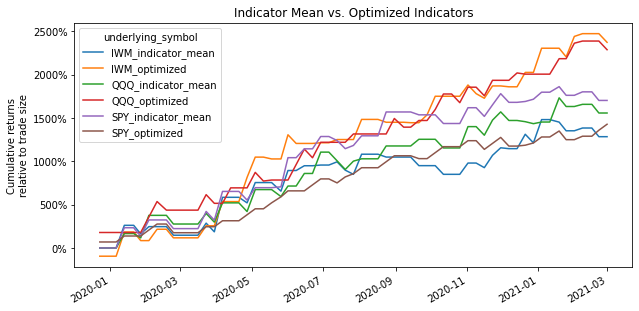

In [ ]:
#@title Compare Optimized Results
optimized_returns = pd.concat([
  spy_1_week_atm_optimization.optimize_calls.iloc[0].returns,
  iwm_1_week_atm_optimization.optimize_calls.iloc[0].returns,
  qqq_1_week_atm_optimization.optimize_calls.iloc[0].returns])
optimized_returns.index = (
    optimized_returns.index.set_levels(
      optimized_returns.index.levels[1] + '_optimized',
      level='underlying_symbol'))

indicator_mean_returns = pd.concat(
    get_returns_with_defaults_params(s) for s in ('SPY', 'IWM', 'QQQ'))
indicator_mean_returns.index = (
    indicator_mean_returns.index.set_levels(
      indicator_mean_returns.index.levels[1] + '_indicator_mean',
      level='underlying_symbol'))
combined_returns =  pd.concat(
    [optimized_returns, indicator_mean_returns]
).sort_index()
ax = combined_returns.droplevel(
    ['strike_pct', 'week_exp']
).sort_index().unstack(
    'underlying_symbol'
).fillna(0).cumsum().plot(
    title='Indicator Mean vs. Optimized Indicators',
    figsize=(10, 5)
)
ax.xaxis.set_label_text('')
ax.yaxis.set_label_text('Cumulative returns\nrelative to trade size')
ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(1))
display(HTML('<h2>Mean Indicator vs. Optimized Performance</h2>'))
get_benchmarks(combined_returns)

In [ ]:
#@title Optimize weights until Dec-2020, reserve afterwards to compare against mean inidicator weight strategy.
hard_coded_space_for_backtest = dict(one_week_atm_hard_coded_space.items())
hard_coded_space_for_backtest['backtest_date_cuttoff'] = (
    pd.Timestamp('2020-12-01'))

n_optimize_calls = 700
spy_1_week_atm_backtest_optimization = OptimizedParameters(
    symbol='SPY',
    n_optimize_calls=n_optimize_calls,
    optimize_space=(indicator_weight_optimize_space
                    + [call_sell_trigger_pct_space]),
    hard_coded_space=hard_coded_space_for_backtest,
).optimize()
iwm_1_week_atm_backtest_optimization = OptimizedParameters(
    symbol='IWM',
    n_optimize_calls=n_optimize_calls,
    optimize_space=(indicator_weight_optimize_space
                    + [call_sell_trigger_pct_space]),
    hard_coded_space=hard_coded_space_for_backtest,
).optimize()
qqq_1_week_atm_backtest_optimization = OptimizedParameters(
    symbol='QQQ',
    n_optimize_calls=n_optimize_calls,
    optimize_space=(indicator_weight_optimize_space
                    + [call_sell_trigger_pct_space]),
    hard_coded_space=hard_coded_space_for_backtest,
).optimize()

<h2>Analysis</h2>
Inconclusive. IWM outperformed the mean indicaotr weights while SPY underperformed.

,annualized_mean,calmar,sharpe
underlying_symbol,,,
IWM_indicator_mean,5.561905,0.649746,1.502370
IWM_optimized,6.623100,0.000000,19.292087
QQQ_indicator_mean,-0.564881,-0.074286,-0.166303
QQQ_optimized,-10.555942,-1.214656,-4.380978
SPY_indicator_mean,-3.389286,-0.490566,-1.603000
SPY_optimized,-10.472024,-0.934109,-4.856093


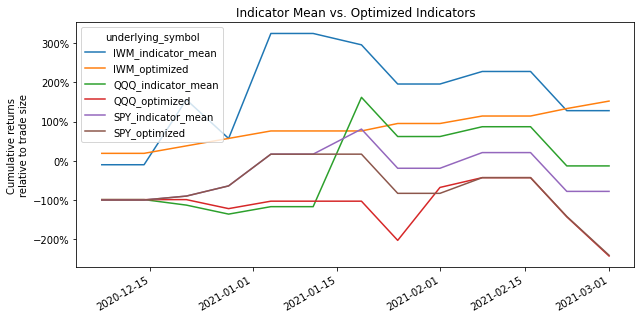

In [ ]:
#@title Compare Optimized IWM vs. SPY

def del_backtest_date_cuttoff(d: typing.Dict) -> typing.Dict:
  if 'backtest_date_cuttoff' in d:
    d = dict(d)
    del d['backtest_date_cuttoff']
  return d

optimized_returns = pd.concat([
  get_returns(
      **del_backtest_date_cuttoff(
          spy_1_week_atm_backtest_optimization.optimize_calls.iloc[0]
          .get_returns_args)),
  get_returns(
      **del_backtest_date_cuttoff(
          iwm_1_week_atm_backtest_optimization.optimize_calls.iloc[0]
          .get_returns_args)),
  get_returns(
      **del_backtest_date_cuttoff(
          qqq_1_week_atm_backtest_optimization.optimize_calls.iloc[0]
          .get_returns_args))])

optimized_returns.index = (
    optimized_returns.index.set_levels(
      optimized_returns.index.levels[1] + '_optimized',
      level='underlying_symbol'))

indicator_mean_returns = pd.concat([
  get_returns_with_defaults_params('SPY'),
  get_returns_with_defaults_params('IWM'),
  get_returns_with_defaults_params('QQQ')])
indicator_mean_returns.index = (
    indicator_mean_returns.index.set_levels(
      indicator_mean_returns.index.levels[1] + '_indicator_mean',
      level='underlying_symbol'))
combined_returns =  pd.concat(
    [optimized_returns, indicator_mean_returns]
).sort_index().loc[pd.IndexSlice['2020-12-02':], :]
ax = combined_returns.droplevel(
    ['strike_pct', 'week_exp']
).sort_index().unstack(
    'underlying_symbol'
).fillna(0).cumsum().plot(
    title='Indicator Mean vs. Optimized Indicators',
    figsize=(10, 5)
)
ax.xaxis.set_label_text('')
ax.yaxis.set_label_text('Cumulative returns\nrelative to trade size')
ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(1))
display(HTML('<h2>Mean Indicator vs. Optimized Performance</h2>'))
get_benchmarks(combined_returns)